# Homework 2 Part 1 - Behavior Cloning and Offline RL

***

Written by Albert Wilcox

In this homework, you'll implement DAgger and Implicit Q learning on the `halfcheetah-medium-replay-v2` task from the [D4RL benchmark](https://github.com/Farama-Foundation/D4RL).

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

import gym
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm
import einops
import os
import copy

from src.utils import (
    get_device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    save_frames_as_gif,
    update_exponential_moving_average,
    return_range
)
from src.d4rl_dataset import D4RLSampler

plt.ion()

/home/atharva/miniconda3/envs/drl/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


***

### Part 0 - Setting up D4RL and Dataset

The first step for training on the D4RL benchmark is to set up the environment. Unfortunately mujoco can be difficult to install. Run the following block to test your install. If you have any issues, Google is your friend :)

In [2]:
import d4rl

/home/atharva/miniconda3/envs/drl/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:45:17


Next we need to initialize our environment and set the random seed for a variety of libraries in order to ensure determinism in our experiments.

For this homework we'll be using the `halfcheetah-medium-replay-v2` environment. This environment involves training a two-legged cheetah to run, and comes with a dataset that consists of data from rolling out a suboptimal SAC agent and exploration data from the SAC replay buffer. Thus, it comes from a wide distribution of policies and contains a good amount of suboptimal data.

In [3]:
SEED: int = 42
ENVIRONMENT_NAME: str='halfcheetah-medium-replay-v2'

# torch related defaults
DEVICE = get_device()
torch.set_default_dtype(torch.float32)

# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
env = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
action_dimension = env.action_space.shape[0]
state_dimension = env.observation_space.shape[0]

logger.info(f'Action Dimension: {action_dimension}')
logger.info(f'Action High: {env.action_space.high}')
logger.info(f'Action Low: {env.action_space.low}')
logger.info(f'State Dimension: {state_dimension}')


2024-11-11 20:35:54.385 | INFO     | src.utils:get_device:52 - Using cuda device.
2024-11-11 20:35:54.387 | INFO     | src.utils:set_seed:38 - Random seed set as 42.
/home/atharva/miniconda3/envs/drl/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
2024-11-11 20:35:54.394 | INFO     | __main__:<module>:18 - Action Dimension: 6
2024-11-11 20:35:54.395 | INFO     | __main__:<module>:19 - Action High: [1. 1. 1. 1. 1. 1.]
2024-11-11 20:35:54.395 | INFO     | __main__:<module>:20 - Action Low: [-1. -1. -1. -1. -1. -1.]
2024-11-11 20:35:54.395 | INFO     | __main__:<module>:21 - State Dimension: 17


Next, we need a dataset. Luckily for us, D4RL provides datasets that are convenient to download and train on. Running the following command should download and cache the dataset and initialize a dataset object before printing out some useful information.

In [4]:
dataset = d4rl.qlearning_dataset(env)

logger.info(f'Dataset type: {type(dataset)}')
logger.info(f'Dataset keys: {dataset.keys()}')
logger.info(f'# Samples: {len(dataset["observations"])}')

load datafile:   0%|                                                                                                      | 0/11 [00:00<?, ?it/s]

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.93it/s]
2024-11-11 20:35:58.562 | INFO     | __main__:<module>:3 - Dataset type: <class 'dict'>
2024-11-11 20:35:58.563 | INFO     | __main__:<module>:4 - Dataset keys: dict_keys(['observations', 'actions', 'next_observations', 'rewards', 'terminals'])
2024-11-11 20:35:58.563 | INFO     | __main__:<module>:5 - # Samples: 201798


In this cell we wrap the D4RL dataset in a sampler. You can comment out the lines at the bottom to make sure everything runs smoothly.

In [5]:

sampler = D4RLSampler(dataset, 256, DEVICE)

# Uncomment the following lines to iterate through the datset and make sure everything runs smoothly
# for _ in tqdm(sampler):
#     pass

### Part 1 - Behavior Cloning

In this part of the homework you'll implement behavior cloning.

Next, train a BC agent by minimizing the negative log likelihood (NLL) of the predicted distribution on datset actions.

You should achieve a maximum normalized reward greater than 0.35 with the provided hyperparameters.

2024-11-11 19:21:52.488 | INFO     | src.utils:get_device:52 - Using cuda device.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:01<00:00, 562.21it/s]
/home/atharva/miniconda3/envs/drl/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
2024-11-11 19:22:15.712 | INFO     | __main__:<module>:44 - Epoch: 5. Loss: -0.0009. Reward: 0.1263 +/- 0.1441
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:01<00:00, 561.92it/s]
2024-11-11 19:22:38.756 | INFO     | __main__:<module>:44 - Epoch: 10. Loss: -0.1092. Reward: 0.1733 +/- 0.1709
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:01<00:00, 561.51it/s]
2024-11-11 19:23:01.734 | INFO

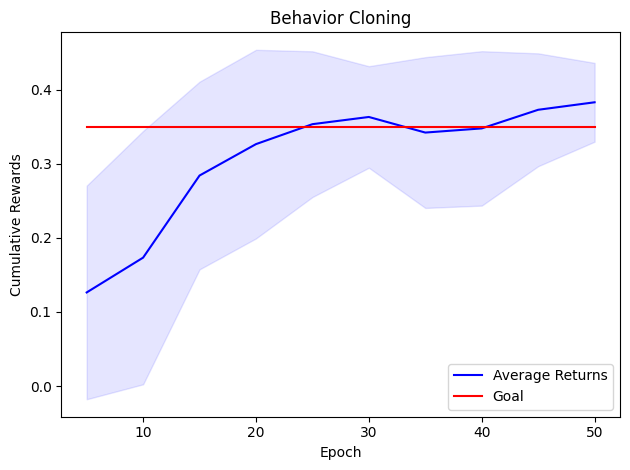

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
from src.networks import GaussianPolicy

################################## Hyper-parameters #########################################

EPOCHS: int = 50
EVAL_FREQ = 5
LOAD_CKPT = False

hidden_dim: int = 256
n_hidden: int = 3
lr: float = 3e-4
WEIGHT_DECAY: float = 3e-4

#############################################################################################

bc_policy = GaussianPolicy(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
optimizer = Adam(bc_policy.parameters(), lr)

if LOAD_CKPT and os.path.exists('bc_policy.pth'):
    ckpt = torch.load('bc_policy.pth')
    bc_policy.load_state_dict(ckpt['state_dict'])
    means = ckpt['means']
    stds = ckpt['stds']
else:
    means, stds = [], []
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in tqdm(sampler):
            state = batch['state'].to(DEVICE)
            action = batch['action'].to(DEVICE)
            
            # Compute negative log likelihood loss on this batch
            policy_dist = bc_policy.pi(state)
            loss = -policy_dist.log_prob(action).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % EVAL_FREQ == 0:
            rew_mean, rew_std = eval_policy(bc_policy, environment_name=ENVIRONMENT_NAME, eval_episodes=50)
            logger.info(f'Epoch: {epoch + 1}. Loss: {total_loss / len(sampler):.4f}. Reward: {rew_mean:.4f} +/- {rew_std:.4f}')
            means.append(rew_mean)
            stds.append(rew_std)
    # Save the policy and learning curve in case there is an issue so you can plot without retraining
    exp_state = {
        'state_dict': bc_policy.state_dict(),
        'means': means,
        'stds': stds
    }
    torch.save(exp_state, 'bc_policy.pth')
epochs = np.arange(EVAL_FREQ, EPOCHS + EVAL_FREQ, step=EVAL_FREQ)
plot_returns(means, stds,'Behavior Cloning', epochs=epochs, goal=0.35)

Now that we've finished training, use the following block to visualize the policy you trained with BC.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 755.69it/s]


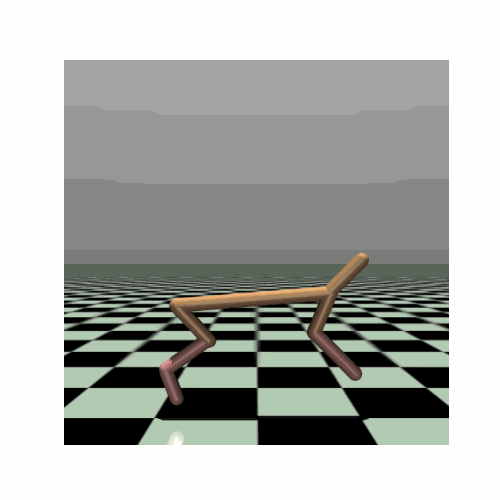

In [7]:
bc_policy.load_state_dict(torch.load('bc_policy.pth')['state_dict'])
frames, total_reward = demo_policy(bc_policy, environment_name=ENVIRONMENT_NAME, steps=200)
gif_path = save_frames_as_gif(frames, method_name='bc')
Image(open(gif_path,'rb').read())

<!-- ### Part 2 - DAgger

BC is great at replicating supervisor actions when the agent is in the data distribution, but this assumption is not always true. Sometimes the agent may enter an out of distribution state and output bad actions. A popular method to handle this issue is [Dataset Aggregation (DAgger)](https://arxiv.org/abs/1011.0686). The key idea behind DAgger is to roll out the learned policy while querying an expert policy on the states the agent encounters, adding the state-expert action pairs to the dataset. 

Luckily for you, we're providing an expert pretrained using the Soft Actor Critic Algorithm, which we'll load and test in the following block. -->

### Part 2 - Implicit Q Learning

In this part you'll implement Implicit Q-Learning (Kostrikov et al., 2021), a popular offline RL algorithm. 

The key idea behind IQL is to use expectile regression to optimize the value functions so that they estimate the values of the higher-performing actions in the dataset, rather than estimating the values of the current policy. This allows you to learn a value function without ever querying the policy, which helps to avoid OOD issues. We would suggest having a look at Kostrikov et al. for a more thorough description of the algorithm.

To start, implement a double Q function below. This can be similar to the code from HW1 but notice the constructor has a different signature.

In [10]:
from src.networks import network
from src.networks import GaussianPolicy
class QNetwork(nn.Module):
    def __init__(self, state_dimension, action_dimension, hidden_dim, n_hidden):
        super(QNetwork, self).__init__()
        # Create two Q networks for double Q learning
        self.q1 = network(state_dimension + action_dimension, 1, hidden_dim, n_hidden)
        self.q2 = network(state_dimension + action_dimension, 1, hidden_dim, n_hidden)

    def forward(self, state, action):
        # Concatenate state and action
        x = torch.cat([state, action], dim=-1)
        
        # Get Q values from both networks
        q1 = self.q1(x)
        q2 = self.q2(x)
        
        return q1, q2

Next, implement a value network below. This should be similar to the Q network, but only condition on states and should only have one network.

In [11]:
class VNetwork(nn.Module):
    def __init__(self, state_dimension, hidden_dim, n_hidden):
        super(VNetwork, self).__init__()

        self.v = network(state_dimension, 1, hidden_dim, n_hidden)

    def forward(self, state):
        v = self.v(state)
        return v

Next, implement the expectile loss, $L^{\tau}_2$, to be used for optimizing the value function. This function is described in Sections 4.1 of Kostrikov et al.

In [12]:
def expectile_loss(diff, expectile=0.8):
    # Compute the expectile loss
    loss = torch.where(diff > 0, expectile * (diff ** 2), (1 - expectile) * (diff ** 2))
    return loss.mean()


Finally, it's time to implement the IQL training loop. There are several steps here:
 * Implement the value function update using the `expectile_loss` function implemented above.
 * Implement the $Q$ function update. The targets for this update should be a bellman backup based on the value function. Don't forget to update the EMA target!
 * Implement the policy update. This should be an NLL loss weighted based on clipped exponentiated advantage estimates

More details about all of these steps can be found in Kostrikov et al.

Once you've finished implementing the training loop run the cell to train your IQL policy. Your policy should get reward greater than 0.4 with a correct implementation and hyperparameters.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 217.35it/s]
/home/atharva/miniconda3/envs/drl/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Epoch: 15. Q Loss: 1.9142. V Loss: 0.0926. P Loss: -1.7175. Reward: 0.0960 +/- 0.0825


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 218.11it/s]


Epoch: 30. Q Loss: 3.4300. V Loss: 0.1948. P Loss: -1.3089. Reward: 0.3231 +/- 0.1027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 211.55it/s]


Epoch: 45. Q Loss: 3.8542. V Loss: 0.2867. P Loss: -0.9153. Reward: 0.3710 +/- 0.0487


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 212.24it/s]


Epoch: 60. Q Loss: 3.6825. V Loss: 0.3344. P Loss: -0.6886. Reward: 0.4155 +/- 0.0138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 214.03it/s]


Epoch: 75. Q Loss: 3.5837. V Loss: 0.3634. P Loss: -0.5434. Reward: 0.4116 +/- 0.0471


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 212.80it/s]


Epoch: 90. Q Loss: 3.3027. V Loss: 0.3657. P Loss: -0.6444. Reward: 0.4167 +/- 0.0455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 213.56it/s]


Epoch: 105. Q Loss: 3.2725. V Loss: 0.3992. P Loss: -0.7585. Reward: 0.4209 +/- 0.0495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 212.17it/s]


Epoch: 120. Q Loss: 3.1893. V Loss: 0.4137. P Loss: -0.6582. Reward: 0.4188 +/- 0.0334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 214.10it/s]


Epoch: 135. Q Loss: 3.1435. V Loss: 0.4120. P Loss: -0.6771. Reward: 0.4192 +/- 0.0495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:03<00:00, 211.11it/s]


Epoch: 150. Q Loss: 3.0471. V Loss: 0.4253. P Loss: -0.6732. Reward: 0.4209 +/- 0.0447


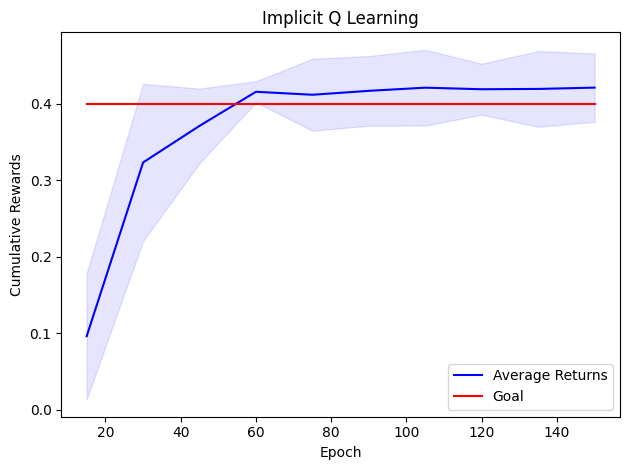

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
EPOCHS = 150
EVAL_FREQ = 15
LOAD_FROM_CKPT = False

# These parameters should work fine but you may tune them if you want to
hidden_dim: int = 256
n_hidden: int = 2
lr: float = 3e-4
discount = 0.99
alpha = 0.005
exp_advantage_max = 100

# TODO: you'll need to choose your own value for the following parameters
tau = 0.7  # paper uses 0.7 for mujoco
beta = 3.0 # paper uses 3.0

min_rew, max_rew = return_range(dataset, 1000)

#############################################################################################

sampler = D4RLSampler(dataset, 256, DEVICE)

iql_policy = GaussianPolicy(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
policy_optimizer = Adam(iql_policy.parameters(), lr)
policy_lr_schedule = CosineAnnealingLR(policy_optimizer, EPOCHS * len(sampler))

v_critic = VNetwork(state_dimension, hidden_dim, n_hidden).to(DEVICE)
v_optimizer = Adam(v_critic.parameters(), lr)

q_critic = QNetwork(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
q_critic_target = copy.deepcopy(q_critic)
q_critic_target.requires_grad_(False)
q_optimizer = Adam(q_critic.parameters(), lr)

means, stds, start_epoch = [], [], 0
if os.path.exists('iql_checkpoint.pth') and LOAD_FROM_CKPT:
    checkpoint = torch.load('iql_checkpoint.pth')

    iql_policy.load_state_dict(checkpoint['iql_policy'])
    policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
    v_critic.load_state_dict(checkpoint['v_critic'])
    v_optimizer.load_state_dict(checkpoint['v_optimizer'])
    q_critic.load_state_dict(checkpoint['q_critic'])
    q_critic_target.load_state_dict(checkpoint['q_critic_target'])
    q_optimizer.load_state_dict(checkpoint['q_optimizer'])
    
    start_epoch = checkpoint['epoch']
    means = checkpoint['means']
    stds = checkpoint['stds']
    
    print(f'Resuming run from epoch {start_epoch}')

for epoch in range(start_epoch, EPOCHS):
    total_q_loss = total_v_loss = total_policy_loss = count = 0
    policy_losses = []
    # for batch in tqdm(dataloader):
    for batch in tqdm(sampler):
        state = batch['state'].to(DEVICE)
        next_state = batch['next_state'].to(DEVICE)
        action = batch['action'].to(DEVICE)
        reward = einops.rearrange(batch['reward'], 'b -> b 1').to(DEVICE)
        reward = reward / (max_rew - min_rew) * 1000
        not_done = einops.rearrange(batch['not_done'], 'b -> b 1').to(DEVICE)

        # TODO: update the state value function (V)
        with torch.no_grad():
            q1, q2 = q_critic_target(state, action)
            q = torch.minimum(q1, q2)
        
        v_pred = v_critic(state)
        v_loss = expectile_loss(q - v_pred, tau)
        
        v_optimizer.zero_grad()
        v_loss.backward()
        v_optimizer.step()

        # TODO: update the state-action value function (Q) and the target
        with torch.no_grad():
            next_v = v_critic(next_state)
            q_target = reward + discount * not_done * next_v

        q1_pred, q2_pred = q_critic(state, action)
        q_loss = F.mse_loss(q1_pred, q_target) + F.mse_loss(q2_pred, q_target)

        q_optimizer.zero_grad()
        q_loss.backward()
        q_optimizer.step()

        # Update target network with EMA
        for param, target_param in zip(q_critic.parameters(), q_critic_target.parameters()):
            target_param.data.copy_(alpha * param.data + (1 - alpha) * target_param.data)

        # TODO: update the policy
        with torch.no_grad():
            v_pred = v_critic(state)
            q1, q2 = q_critic(state, action)
            q = torch.minimum(q1, q2)
            advantage = q - v_pred
            # Paper uses beta=3.0 for temperature parameter
            exp_advantage = torch.exp(beta*advantage).clamp(0, exp_advantage_max)

        dist = iql_policy.pi(state)
        policy_loss = -dist.log_prob(action) * exp_advantage
        policy_loss = policy_loss.mean()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        policy_lr_schedule.step()
        total_v_loss += v_loss.item()
        total_q_loss += q_loss.item()
        total_policy_loss += policy_loss.item()
        count += 1
        
    if (epoch + 1) % EVAL_FREQ == 0:
        rew_mean, rew_std = eval_policy(iql_policy, environment_name=ENVIRONMENT_NAME, eval_episodes=50)
        print(f'Epoch: {epoch + 1}. Q Loss: {total_q_loss / count:.4f}. V Loss: {total_v_loss / count:.4f}. P Loss: {total_policy_loss / count:.4f}. Reward: {rew_mean:.4f} +/- {rew_std:.4f}')
        means.append(rew_mean)
        stds.append(rew_std)

    # Save a checkpoint so that you can resume training if it crashes
    checkpoint = {
        'iql_policy': iql_policy.state_dict(),
        'policy_optimizer': policy_optimizer.state_dict(),
        'v_critic': v_critic.state_dict(),
        'v_optimizer': v_optimizer.state_dict(),
        'q_critic': q_critic.state_dict(),
        'q_critic_target': q_critic_target.state_dict(),
        'q_optimizer': q_optimizer.state_dict(),
        'epoch': epoch + 1,
        'means': means,
        'stds': stds
    }
    torch.save(checkpoint, 'iql_checkpoint.pth')

epochs = np.arange(EVAL_FREQ, EPOCHS + EVAL_FREQ, step=EVAL_FREQ)
plot_returns(means, stds, 'Implicit Q Learning', goal=0.4, epochs=epochs)

Now that we've finished training our IQL policy we can visualize it in the block below.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1010.72it/s]


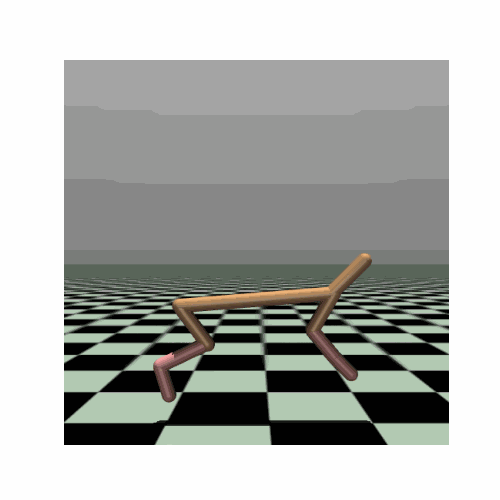

In [14]:
iql_policy.load_state_dict(torch.load('iql_checkpoint.pth')['iql_policy'])
frames, total_reward = demo_policy(iql_policy, environment_name=ENVIRONMENT_NAME, steps=200)
gif_path = save_frames_as_gif(frames, method_name='iql')
Image(open(gif_path,'rb').read())

Congrats on finishing the offline portion of Assignment 2! Hopefully you enjoyed yourself. Make sure that the visualizations are showing and that there are four outputs from this notebook in the artifacts folder:
 * `bc_policy.gif`
 * `iql_policy.gif`
 * `Behavior Cloning_returns.png`
 * `Implicit Q Learning_results.png`

When you're done: export this notebook as an **HTML file** for final submission.